# Twitter Sentiment Analysis.

## Business Problem.

We want to analyze a COVID-19 Twitter dataset to understand how positive and negative trends spread after news announcements.

Key Questions:

How do positive and negative sentiments spread among users after a news announcement related to COVID-19?

Purpose:

Help media outlets measure the impact of their announcements on public sentiment.

Goals:

Track sentiment trends over time.


## Dataset location and download instructions.

[Covid-19 Twitter Dataset](https://www.kaggle.com/datasets/arunavakrchakraborty/covid19-twitter-dataset/data)


* Place datasets into ```Data``` folder if running the notebook locally.
* Upload the files into ```/content``` root file folder of Colab environment.

## Installing the required modules.

We'll start with installing the requirements [available here](https://github.com/leksea/capstone-twitter-sentiment-analysis/blob/main/requirements.txt).

In [200]:
!wget https://raw.githubusercontent.com/leksea/capstone-twitter-sentiment-analysis/main/requirements.txt
!pip install -r 'requirements.txt'

--2024-12-29 07:00:26--  https://raw.githubusercontent.com/leksea/capstone-twitter-sentiment-analysis/main/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 138 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]     138  --.-KB/s    in 0s      

2024-12-29 07:00:27 (7.40 MB/s) - ‘requirements.txt’ saved [138/138]



### Importing modules.

In [201]:
# built-in modules
import os
import string
import re
import glob
import time
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor
import json
from collections import Counter
# url processing for extracting the coordinates
import requests
# progress bar monitoring
from tqdm import tqdm
# data manupulation, analysis
import numpy as np
import pandas as pd
# general data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# networkx for user connection visualization
import networkx as nx
# world maps
import folium
from folium import plugins
from folium.plugins import HeatMap
import branca.colormap as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
#for location standartization
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
# world cloud
from wordcloud import WordCloud
# Natural Language Processing (NLP)
import nltk
from emot.emo_unicode import UNICODE_EMOJI
import emoji
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk import pos_tag, ne_chunk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
# Classification
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline
## GLOBAL VARIABLES
# stop words for tokenizer
nltk.download('stopwords')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
# Initialize geolocator globally for efficient geocoding cache
geolocator = Nominatim(user_agent="batch-geocoding")
# Enable tqdm for pandas
tqdm.pandas()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Supplemental Functions Will be Defined Here.
* ```def determine_data_dir()```
* ```def display_categorical_vals(df)```
* ```def has_special_chars(location) ```
* ```def save_cache_to_json(cache, file_path="location_cache.json")```
* ```def load_cache_to_json(cache, file_path="location_cache.json")```
* ```def geocode_location(location)```
* ```def batch_geocode(locations)```
* ```def extract_word(location, position="first")```
* ```def split_geocoded_location(location)```
* ```def get_coordinates(input_type, name, output_as='center', retries=3, delay=5)```
* ```def add_coordinates_with_progress(df, city_col='city', state_col='state', country_col='country')```
* ```def color(magnitude)```
* ```def generateBaseMap(input_type, df, default_location=[40.693943, -73.985880], default_zoom_start=2)```
* ```def extract_html_source(source_text)```
* ```def replace_emoticons_with_emojis(text)```
* ```def process_tweet_data(tweet, emoji_list=None)```
* ```def clean_tweets_with_progress(df, text_col='tweet_text')```
* ```def preprocess_text_with_ngrams(df, text_column, ngram_range=(2, 3), max_features=5000)```
* ``` ```
* ``` ```
* ``` ```
* ``` ```
* ``` ```







In [202]:
# Supplemental function to determine data directory
# Input: none
# Output: Data directory, depending on runtime environment.

def determine_data_dir():
    """
    Determines the data directory based on the execution environment:
    - Local: Uses 'Data' directory in the current working directory.
    - Cloud (e.g., Google Colab): Uses '/content' as the data directory.

    Returns:
        str: Path to the appropriate data directory.
    """
    if 'COLAB_GPU' in os.environ:  # Check if running in Google Colab
        data_dir = "/content"
        print(f"Running in Google Colab. Using data directory: {data_dir}")
    else:
        data_dir = os.path.join(os.getcwd(), "Data")
        print(f"Running locally. Using data directory: {data_dir}")

        # Ensure the 'Data' directory exists locally
        if not os.path.isdir(data_dir):
            print(f"The directory '{data_dir}' does not exist. Please create it and place the data files there.")
            raise FileNotFoundError(f"'{data_dir}' directory is required for local execution.")

    return data_dir

In [203]:
# Supplemental function will display unique values for all categorical columns in a dataframe.
def display_categorical_vals(df):
    # select categorical columns
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns

    # print categorical columns and their unique values
    for col in categorical_columns:
        unique_values = df[col].unique()
        print(f"Column '{col}' has unique values: {unique_values}")

In [204]:
# define a function to check for special characters
def has_special_chars(location):
    return bool(re.search(r'[^\w\s,.-]', location))  # check for non-alphanumeric and non-space chars

In [205]:
def save_cache_to_json(cache, file_path="location_cache.json"):
    """
    Saves the location cache to a JSON file.

    Args:
        cache (dict): The cache dictionary to save.
        file_path (str): The file path where the cache will be saved.
    """
    with open(file_path, "w") as f:
        json.dump(cache, f)
    print(f"Cache saved to {file_path}")

In [206]:
def load_cache_from_json(file_path="location_cache.json"):
    """
    Loads the location cache from a JSON file.

    Args:
        file_path (str): The file path from where the cache will be loaded.

    Returns:
        dict: The loaded cache dictionary.
    """
    try:
        with open(file_path, "r") as f:
            cache = json.load(f)
        print(f"Cache loaded from {file_path}")
        return cache
    except FileNotFoundError:
        print(f"No cache file found at {file_path}. Starting with an empty cache.")
        return {}

In [207]:
# Dictionary to cache geocoding results
try:
    # Initialize cache from file
    location_cache = load_cache_from_json("location_cache.json")
except FileNotFoundError:
    # If the file doesn't exist, initialize an empty cache
    location_cache = {}

# Supplemental function to use a geocoding API for location resolution
def geocode_location(location):
    """
    Resolve location using a geocoding API with caching.
    Returns results in City, State, Country format.
    """
    # Check cache first
    if location in location_cache:
        return location_cache[location]

    try:
        # Add a delay to respect API rate limits
        geo = geolocator.geocode(location, addressdetails=True, exactly_one=True, timeout=10)
        if geo:
            # Default: Extract the address components
            address = geo.raw.get('address', {})
            city = address.get('city') or address.get('town') or address.get('village') or address.get('hamlet')
            state = address.get('state')
            country = address.get('country')

            # Fallback: Parse city and country from display_name if missing
            if not city:
                try:
                    city = geo.raw['display_name'].split(',')[0].strip()
                except (KeyError, IndexError):
                    city = "Unknown"
            if not country:
                try:
                    country = geo.raw['display_name'].split(',')[-1].strip()
                except (KeyError, IndexError):
                    country = "Unknown"
            # Fallback: Parse state dynamically from display_name if missing or ambiguous
            if not state:
                try:
                    components = geo.raw['display_name'].split(',')
                    components = [comp.strip() for comp in components]
                    for i in range(len(components) - 1, -1, -1):  # Iterate backwards
                        if 'County' not in components[i] and "United States" not in components[i]:
                            state = components[i]
                            break
                except (KeyError, IndexError):
                    state = "Unknown"

            # Avoid redundancy: "Country, Unknown, Country"
            if city == country:
                city = "Unknown"
            if state == country:
                state = "Unknown"

            # Construct the result in the desired format
            result = f"{city}, {state}, {country}"
        else:
            result = "Unknown"
    except (GeocoderTimedOut, GeocoderServiceError) as e:
        result = f"Error: {e}"

    # Cache the result
    location_cache[location] = result
    return result

Cache loaded from location_cache.json


In [208]:
# geocode multiple locations in parallel using ThreadPoolExecutor
def batch_geocode(locations):
    """
    Geocode multiple locations in parallel using ThreadPoolExecutor.
    """
    results = []
    with ThreadPoolExecutor(max_workers=5) as executor:  # max_workers can be adjusted as needed
        # Use tqdm to wrap the executor's map method for progress tracking
        for result in tqdm(executor.map(geocode_location, locations), \
                           total=len(locations), desc="Geocoding Progress"):
            results.append(result)
    return results

In [209]:
# function to extract the first or last word from a location string
def extract_word(location, position="first"):
    """
    Extract the first or last word from a location string.

    Args:
        location (str): The location string to process.
        position (str): 'first' to extract the first word, 'last' to extract the last word.

    Returns:
        str: The extracted word or 'Unknown' if the location is empty or invalid.
    """
    words = location.split()
    if words:
        return words[0] if position == "first" else words[-1]
    return "Unknown"

In [210]:
# function to split geocoded_location into City, State, and Country
def split_geocoded_location(location):
    if pd.notna(location):
        parts = location.split(",")
        parts = [p.strip() for p in parts]  # remove extra whitespace
        city = parts[0] if len(parts) > 0 else "Unknown"
        state = parts[1] if len(parts) > 1 else "Unknown"
        country = parts[2] if len(parts) > 2 else "Unknown"
        return city, state, country
    return "Unknown", "Unknown", "Unknown"

In [211]:
# Update get_coordinates function to include User-Agent
def get_coordinates(input_type, name, output_as='center', retries=3, delay=5):
    """
    Fetch coordinates of a city/state/country using Nominatim API with retry logic.

    Args:
        input_type (str): 'country', 'state', or 'city' to specify the type of input.
        name (str): Name of the location.
        output_as (str): 'center' or 'boundingbox' for coordinate type.
        retries (int): Number of retry attempts.
        delay (int): Delay between retries in seconds.

    Returns:
        list: [latitude, longitude]. Returns [0, 0] on failure.
    """
    url = f"http://nominatim.openstreetmap.org/search"
    headers = {
        "User-Agent": "ColabGeocoder/1.0 (leksea@gmail.com)"
    }
    params = {
        input_type: name,
        "format": "json",
        "polygon": 0
    }

    for attempt in range(retries):
        try:
            response = requests.get(url, headers=headers, params=params)
            response.raise_for_status()
            data = response.json()
            if data:
                if output_as == 'center':
                    return [float(data[0]['lat']), float(data[0]['lon'])]
                elif output_as == 'boundingbox':
                    return [float(coord) for coord in data[0]['boundingbox']]
        except requests.exceptions.RequestException as e:
            print(f"Error fetching coordinates for {name}: {e}")
            if attempt < retries - 1:
                print(f"Retrying in {delay} seconds... ({attempt + 1}/{retries})")
                time.sleep(delay)
            else:
                print(f"Failed to fetch coordinates for {name} after {retries} attempts.")
                return [0, 0]
    return [0, 0]

# Updated add_coordinates_with_progress function
def add_coordinates_with_progress(df, city_col='city', state_col='state', country_col='country'):
    """
    Add latitude and longitude coordinates to a DataFrame based on unique combinations
    of City, State, and Country, only for rows where these are not 'Unknown'.

    Args:
        df (pd.DataFrame): The input DataFrame.
        city_col (str): Column name for city.
        state_col (str): Column name for state.
        country_col (str): Column name for country.

    Returns:
        pd.DataFrame: The updated DataFrame with 'Latitude' and 'Longitude' columns.
    """
    # Create a unique DataFrame of City, State, Country combinations
    unique_locations = df[(df[city_col] != 'Unknown') &
                          (df[state_col] != 'Unknown') &
                          (df[country_col] != 'Unknown')][[city_col, state_col, country_col]].drop_duplicates()

    # Define a helper function to fetch coordinates
    def fetch_coords(row):
        location_name = f"{row[city_col]}, {row[state_col]}, {row[country_col]}"
        return get_coordinates('city', location_name)

    # Add Latitude and Longitude columns to the unique locations
    unique_locations[['latitude', 'longitude']] = unique_locations.progress_apply(fetch_coords, axis=1, result_type='expand')

    # Create a mapping dictionary for efficient lookup
    location_to_coords = unique_locations.set_index([city_col, state_col, country_col])[['latitude', 'longitude']].to_dict('index')

    # Initialize Latitude and Longitude in the main DataFrame
    df['latitude'], df['longitude'] = 0, 0

    # Map coordinates back to the original DataFrame
    for index, row in df.iterrows():
        key = (row[city_col], row[state_col], row[country_col])
        if key in location_to_coords:
            df.at[index, 'latitude'] = location_to_coords[key]['latitude']
            df.at[index, 'longitude'] = location_to_coords[key]['longitude']

    return df

In [212]:
# Function to determine marker color based on tweet count
def color(magnitude):
    """
    Returns a color based on the magnitude using a hot-to-cool color map.
    """
    if magnitude >= 2000:
        return 'red'  # Hot color for high magnitude
    elif 500 <= magnitude < 2000:
        return 'orange'  # Medium-hot color
    elif 100 <= magnitude < 500:
        return 'yellow'  # Neutral color
    elif 50 <= magnitude < 100:
        return 'lightblue'  # Medium-cool color
    else:
        return 'blue'  # Cool color for low magnitude

# Function to generate the heatmap
def generateBaseMap(input_type, df, default_location=[37.774929, -122.419416], default_zoom_start=2):
    """
    Function to generate a heatmap with markers for tweet distribution.

    Args:
        input_type (str): 'country' or 'city' to specify the type of heatmap.
        df (pd.DataFrame): DataFrame containing latitude, longitude, tweet count, and name.
        default_location (list): Default map center location as [latitude, longitude].
        default_zoom_start (int): Default zoom level for the map.

    Returns:
        folium.Map: A folium map object with heatmap and markers.
    """
    # Initialize the base map
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    marker_cluster = plugins.MarkerCluster().add_to(base_map)

    # Add the heatmap
    HeatMap(data=df[['latitude', 'longitude']].values.tolist(), radius=20, max_zoom=13).add_to(base_map)

    # Add markers with popups
    for lat, lon, tweet_count, name in zip(df['latitude'], df['longitude'], df['retweet_count'], df.iloc[:, 0]):
        popup_content = folium.Popup(f"{name}<br>{tweet_count} tweets", max_width=300)
        folium.Marker(
            location=[lat, lon],
            popup=popup_content,
            icon=folium.Icon(color=color(tweet_count), icon='twitter', prefix='fa')
        ).add_to(marker_cluster)

    # Add a colormap legend
    min_val, max_val = df['retweet_count'].min(), df['retweet_count'].max()
    colormap = cm.LinearColormap(colors=['blue', 'yellow', 'red'], vmin=min_val, vmax=max_val)
    colormap.caption = f"{input_type.title()} Distribution of COVID-19 Tweets"
    colormap.add_to(base_map)

    return base_map

In [213]:
# function to extract readable source from HTML content
def extract_html_source(source_text):
    """
    Extracts the readable text (e.g., 'Twitter for Android') from the source HTML string.

    Args:
        source_text (str): The raw HTML string in the source column.

    Returns:
        str: The cleaned, readable source text.
    """
    return re.sub(r'<.*?>', '', str(source_text)).strip()  # remove HTML tags

In [214]:
#define a dictionary mapping emoticons to emojis
emoticon_to_emoji = {
    ":)": "😊",
    ":D": "😃",
    ":(": "☹️",
    ":/": "😕",
    ":P": "😛",
    ";)": "😉",
    ":'(": "😢",
    ":o": "😮",
    ":|": "😐",
    ":))": "😂",
    ":*": "😘",
    "xD": "😆"
}

def replace_emoticons_with_emojis(text):
    """
    Replaces emoticons in the text with corresponding emojis.

    Args:
        text (str): The input text.

    Returns:
        str: Text with emoticons replaced by emojis.
    """
    # Use regex to find and replace emoticons
    for emoticon, emoji in emoticon_to_emoji.items():
        text = re.sub(re.escape(emoticon), emoji, text)
    return text

In [215]:
# big cleaning function
def process_tweet_data(tweet, emoji_list=None):
    """
    Processes a tweet to extract mentions, hashtags, retweets, emojis, hyperlinks, and cleaned text.

    Args:
        tweet (str): The raw tweet text.
        emoji_list (list): List of emojis to extract. Defaults to keys of UNICODE_EMOJI.

    Returns:
        dict: Dictionary with extracted components and cleaned text.
    """
    # ensure input is a string
    tweet = str(tweet)
    # default emoji list if not provided
    if emoji_list is None:
        emoji_list = list(UNICODE_EMOJI.keys())

    # extract mentions
    mentions = re.findall(r'@\w+', tweet)

    # extract hashtags
    hashtags = re.findall(r'#\w+', tweet)

    # check for retweets and extract username after RT
    retweets = re.findall(r'^RT @(\w+)', tweet)
    retweet_user = retweets[0] if retweets else None

    # extract hyperlinks before emoji
    hyperlinks = re.findall(r'https?://[^\s]+|www\.[^\s]+', tweet)
    tweet = re.sub(r'https?://[^\s]+|www\.[^\s]+', '', tweet) #Remove URL

    # extract emojis
    tweet = replace_emoticons_with_emojis(tweet)
    emojis = ''.join([char for char in tweet if char in emoji_list])

    # replace emojis with text
    tweet = emoji.demojize(tweet).replace('_', ' ')

    # remove mentions, hashtags, retweets, emojis, and hyperlinks from the tweet
    cleaned_text = re.sub(r'@\w+', '', tweet)  # Remove mentions
    cleaned_text = re.sub(r'#\w+', '', cleaned_text)  # Remove hashtags
    cleaned_text = re.sub(r'^RT', '', cleaned_text)   # Remove retweets
    cleaned_text = ''.join([char for char in cleaned_text if char not in emoji_list])  # Remove emojis

    # remove special characters, extra spaces, numbers
    cleaned_text = re.sub(r'[{}]'.format(re.escape(string.punctuation)), '', cleaned_text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    cleaned_text = re.sub(r'\d+', '', cleaned_text)

    #lowercase the text, remove numbers
    cleaned_text = cleaned_text.lower()
    return {
        'mentions': mentions,
        'hashtags': hashtags,
        'retweets': retweets,
        'emojis': emojis,
        'hyperlinks': hyperlinks,
        'cleaned_text': cleaned_text
    }

In [216]:
# function to process the entire DataFrame with progress tracking
def clean_tweets_with_progress(df, text_col='tweet_text'):
    """
    Cleans tweet data in the specified column and adds extracted components as new columns.

    Args:
        df (pd.DataFrame): DataFrame containing tweets.
        text_col (str): Column name containing the tweet text.

    Returns:
        pd.DataFrame: Updated DataFrame with new columns for cleaned text and extracted components.
    """
    # Apply the cleaning function with a progress bar
    processed_data = df[text_col].progress_apply(process_tweet_data)

    # Expand the processed data dictionary into separate columns
    extracted_columns = pd.DataFrame(processed_data.tolist())
    return pd.concat([df, extracted_columns], axis=1)

In [217]:
# Stop words and lemmatizer initialization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text_with_ngrams(df, text_column, ngram_range=(2, 3), max_features=5000):
    """
    Preprocesses text data by tokenizing, removing stop words, lemmatizing, and computing n-grams.

    Args:
        df (pd.DataFrame): Input DataFrame containing the text column.
        text_column (str): Name of the column with raw text to preprocess.
        ngram_range (tuple): Range of n-grams to compute (e.g., (2, 3) for bi-grams and tri-grams).
        max_features (int): Maximum number of n-gram features.

    Returns:
        tuple: Processed DataFrame and sparse matrix of n-grams.
    """
    # Tokenization
    df['tokenized_text'] = df[text_column].progress_apply(word_tokenize)

    # Stop word removal
    df['filtered_tokens'] = df['tokenized_text'].progress_apply(
        lambda tokens: [word for word in tokens if word.lower() not in stop_words]
    )

    # Lemmatization
    df['lemmatized_tokens'] = df['filtered_tokens'].progress_apply(
        lambda tokens: [lemmatizer.lemmatize(word) for word in tokens]
    )

    # Combine tokens back into text for n-gram computation
    df['lemmatized_text'] = df['lemmatized_tokens'].progress_apply(lambda tokens: ' '.join(tokens))

    # Compute n-grams
    vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=max_features)
    ngram_matrix = vectorizer.fit_transform(df['lemmatized_text'])

    return df, ngram_matrix, vectorizer

## Loading The Covid-19 Twitter Datasets.

We're working with multiple CSV files.

In [218]:
## Loading the files
# determine the data directory
data_dir = determine_data_dir()

# locate all CSV files in the determined directory
files_pattern = os.path.join(data_dir, "*.csv")
files = glob.glob(files_pattern)

# check if files are found
if not files:
    print(f"No CSV files found in directory: {data_dir}")
else:
     # load and inspect each file
    dfs = []  # to store valid DataFrames
    for file in files:
        try:
            # load the DataFrame
            df = pd.read_csv(file)
            rows, cols = df.shape
            print(f"File: {file} | Rows: {rows}, Columns: {cols}")

            # skip empty files or files with no columns
            if rows == 0 or cols == 0:
                print(f"Skipping empty or invalid file: {file}")
                continue

            # append to list if valid
            dfs.append(df)

        except Exception as e:
            print(f"Error loading file {file}: {e}")

    # concatenate all valid DataFrames
    if dfs:
        data = pd.concat(dfs, ignore_index=True)
        print(f"Data loaded successfully with {data.shape[0]} rows and {data.shape[1]} columns.")
        print(data.head())
    else:
        print("No valid DataFrames to concatenate.")

Running in Google Colab. Using data directory: /content
File: /content/Covid-19 Twitter Dataset (Apr-Jun 2020).csv | Rows: 143903, Columns: 17
File: /content/Covid-19 Twitter Dataset (Apr-Jun 2021).csv | Rows: 147475, Columns: 17
File: /content/Covid-19 Twitter Dataset (Aug-Sep 2020).csv | Rows: 120509, Columns: 17
Data loaded successfully with 411887 rows and 17 columns.
             id  created_at  \
0  1.250000e+18  2020-04-19   
1  1.250000e+18  2020-04-19   
2  1.250000e+18  2020-04-19   
3  1.250000e+18  2020-04-19   
4  1.250000e+18  2020-04-19   

                                              source  \
0  <a href="http://twitter.com/download/android" ...   
1  <a href="http://twitter.com/download/android" ...   
2  <a href="http://twitter.com/download/iphone" r...   
3  <a href="http://twitter.com/download/iphone" r...   
4  <a href="http://twitter.com/download/android" ...   

                                       original_text lang  favorite_count  \
0  RT @GlblCtzn: .@priya

## Exploratory Data Analysis.
### Data Understanding and Cleaning.

We'll start with getting general information about the dataset and identify the columns of interest.

In [219]:
# get general info about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411887 entries, 0 to 411886
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               411883 non-null  float64
 1   created_at       411885 non-null  object 
 2   source           411587 non-null  object 
 3   original_text    411885 non-null  object 
 4   lang             411884 non-null  object 
 5   favorite_count   411884 non-null  float64
 6   retweet_count    411884 non-null  float64
 7   original_author  411884 non-null  object 
 8   hashtags         97775 non-null   object 
 9   user_mentions    295207 non-null  object 
 10  place            293775 non-null  object 
 11  clean_tweet      409915 non-null  object 
 12  compound         411887 non-null  float64
 13  neg              411887 non-null  float64
 14  neu              411887 non-null  float64
 15  pos              411887 non-null  float64
 16  sentiment        411887 non-null  obje

In [220]:
# info about the numeric columns
data.describe()

,id,favorite_count,retweet_count,compound,neg,neu,pos
count,4.118830e+05,411884.000000,411884.000000,411887.000000,411887.000000,411887.000000,411887.000000
mean,1.324197e+18,0.216726,1585.174163,0.008415,0.090920,0.807021,0.102052
std,5.902218e+16,6.332250,9423.896052,0.370853,0.152717,0.200474,0.157080
min,1.250000e+18,0.000000,0.000000,-0.992500,0.000000,0.000000,0.000000
25%,1.260000e+18,0.000000,1.000000,-0.102700,0.000000,0.667000,0.000000
50%,1.310000e+18,0.000000,15.000000,0.000000,0.000000,0.819000,0.000000
75%,1.395011e+18,0.000000,243.000000,0.226300,0.180000,1.000000,0.200000
max,1.409140e+18,2923.000000,416923.000000,0.980500,1.000000,1.000000,1.000000


In [221]:
# select subset of tweets we'll be working with:
cols_to_keep = ['id', 'source', 'created_at', 'original_text', \
                'lang', 'favorite_count', 'retweet_count', 'original_author', \
                'hashtags', 'user_mentions', 'place', 'neg', 'neu', 'pos']
tweets_df = data[cols_to_keep].copy()

In [222]:
display_categorical_vals(tweets_df)

Column 'source' has unique values: ['<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>'
 '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'
 '<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>'
 ...
 '<a href="https://www.marinebusinessworld.com/" rel="nofollow">MBWautotweet</a>'
 '<a href="http://www.sciencespeaksblog.org" rel="nofollow">Science Speaks Blog</a>'
 '<a href="https://cms2.poz.com" rel="nofollow">Hep Auto Tweet</a>']
Column 'created_at' has unique values: ['2020-04-19' '2020-04-22' '2020-04-23' '2020-04-24' '2020-04-25'
 '2020-04-26' '2020-04-27' '2020-04-28' nan '2020-04-29' '2020-04-30'
 '2020-05-01' '2020-05-02' '2020-05-03' '2020-05-04' '2020-05-05'
 '2020-05-06' '2020-05-07' '2020-05-08' '2020-05-09' '2020-05-10'
 '2020-05-11' '2020-05-12' '2020-05-13' '2020-05-14' '2020-05-15'
 '2020-05-16' '2020-05-17' '2020-05-18' '2020-05-19' '2020-05-20'
 '2020-05-22' '2020-05-23' '2020-05-

### Data Type Conversion.

In [223]:
#rename date column for clarity and convert to date
tweets_df.rename(columns={'created_at': 'date'}, inplace=True)
tweets_df['date'] = pd.to_datetime(tweets_df['date'])

Follow by exploratory data analysis:
* What were daily tweet patters?
* What were the top 20 days with most tweets?  

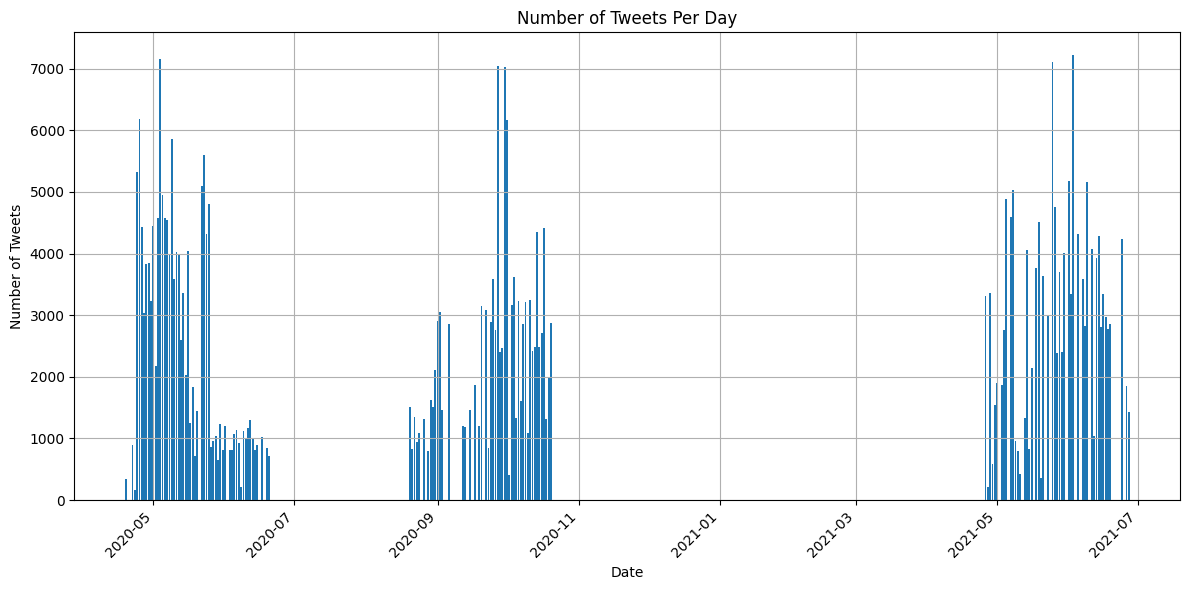

In [224]:
# exploratory analysis: plot number of tweets per day
# group by date and count tweets
tweets_per_day = tweets_df.groupby(tweets_df['date'].dt.date)['id'].count()

plt.figure(figsize=(12, 6))
plt.bar(tweets_per_day.index, tweets_per_day.values)
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.title("Number of Tweets Per Day")
plt.grid(True)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [225]:
# exploratory analysis: list the top 20 days with the most tweets
# rename columns for clarity
tweets_per_day.columns = ['date', 'tweet_count']

# sort by tweet count and get the top 20
top_20_days = tweets_per_day.sort_values(ascending=False).head(20)

# display the result
print(top_20_days)

date
2021-06-03    7229
2020-05-04    7165
2021-05-25    7114
2020-09-27    7040
2020-09-30    7028
2020-04-25    6178
2020-10-01    6166
2020-05-09    5857
2020-05-23    5600
2020-04-24    5323
2021-06-01    5175
2021-06-09    5158
2020-05-22    5102
2021-05-08    5032
2020-05-05    4949
2021-05-05    4886
2020-05-25    4804
2021-05-26    4750
2021-05-07    4586
2020-05-06    4575
Name: id, dtype: int64


### Evaluating and Handling Missing Values.
Before coming up with the strategy for each column, we'll check the contents of categorical data and the distributiuon of NaNs.

* It would make sence that fields like ```hashtags``` and ```user_mentions``` would have missing values and we'll leave it as it is.
* We'll check the ```lang``` and ```place``` columns.


In [226]:
# number of NaNs in lang
sum(tweets_df.lang.isna())

3

In [227]:
# look at the tweet text
tweets_df[tweets_df.lang.isna()]

,id,source,date,original_text,lang,favorite_count,retweet_count,original_author,hashtags,user_mentions,place,neg,neu,pos
23125,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,1.000,0.0
236779,1.400490e+18,"<a href=""http://twitter.com/download/android"" ...",2021-06-03,@santoshmt7666 @globaltimesnews The COVID-19 d...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.394,0.606,0.0
368535,1.310000e+18,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,1.000,0.0


The only 3 rows where language is missing are missing the original text, so we'll discard them.

In [228]:
# drop rows where 'lang' is NaN
tweets_df = tweets_df.dropna(subset=['lang'])

# verify the changes
print(f"Number of NaNs in 'lang' after dropping: {sum(tweets_df.lang.isna())}")

# drop the lang column from the df
tweets_df = tweets_df.drop(columns=['lang'])

Number of NaNs in 'lang' after dropping: 0


In [229]:
tweets_df

,id,source,date,original_text,favorite_count,retweet_count,original_author,hashtags,user_mentions,place,neg,neu,pos
0,1.250000e+18,"<a href=""http://twitter.com/download/android"" ...",2020-04-19,RT @GlblCtzn: .@priyankachopra is calling on l...,0.0,31.0,RJIshak,NaN,"GlblCtzn, priyankachopra",Jakarta Capital Region,0.000,0.452,0.548
1,1.250000e+18,"<a href=""http://twitter.com/download/android"" ...",2020-04-19,RT @OGSG_Official: OGUN STATE SUPPORT FOR CBN-...,0.0,61.0,makinwaoluwole,NaN,OGSG_Official,Nigeria,0.000,0.602,0.398
2,1.250000e+18,"<a href=""http://twitter.com/download/iphone"" r...",2020-04-19,RT @AdvoBarryRoux: These 5 police officials ba...,0.0,1.0,TembeAmu,NaN,AdvoBarryRoux,NaN,0.000,0.851,0.149
3,1.250000e+18,"<a href=""http://twitter.com/download/iphone"" r...",2020-04-19,RT @MobilePunch: COVID-19: Oyo discharges two ...,0.0,0.0,ilyasrabiu,NaN,MobilePunch,"Lagos, Nigeria",0.000,1.000,0.000
4,1.250000e+18,"<a href=""http://twitter.com/download/android"" ...",2020-04-19,My Condolences to the Family of those who did ...,0.0,13869.0,bucketeconomist,Covid_19,NaN,NaN,0.000,1.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
411882,1.320000e+18,"<a href=""https://about.twitter.com/products/tw...",2020-10-20,RT @Reuters: Exclusive: AstraZeneca U.S. COVID...,0.0,51.0,Sabahatjahan28,NaN,Reuters,India,0.000,1.000,0.000
411883,1.320000e+18,"<a href=""http://twitter.com/#!/download/ipad"" ...",2020-10-20,"RT @AndrewTSaks: 5,000+ workers from 130+ coun...",0.0,36.0,jefwintermans,NaN,AndrewTSaks,"Den Haag, Nederland",0.211,0.789,0.000
411884,1.320000e+18,"<a href=""https://mobile.twitter.com"" rel=""nofo...",2020-10-20,Culture of China-Brilliance of Huaxing\nCelebr...,0.0,9.0,ChinaEmbOttawa,NaN,NaN,"515 St. Patrick Street, Ottawa",0.191,0.809,0.000
411885,1.320000e+18,"<a href=""https://mobile.twitter.com"" rel=""nofo...",2020-10-20,Trump called CNN 'bastards' for covering Covid...,0.0,31451.0,maetsfollufdaeh,NaN,NaN,NaN,0.304,0.696,0.000


In [230]:
#rename place column to location for clarity
tweets_df.rename(columns={'place': 'location'}, inplace=True)

In [231]:
# count of NaNs
sum(tweets_df.location.isna())

118109

In [232]:
# fill location NaNs with Unknown
tweets_df.fillna(value={'location':'Unknown'}, inplace=True)

### Data Cleaning.

Here we'll see if location can be cleaned up for further visualization. We'll start with checking the locations with at least 10 tweets.  

In [233]:
# calculate value counts for the 'location' column
location_counts = tweets_df.location.value_counts()

# filter to keep locations with at least 20 occurrences
filtered_locations = location_counts[location_counts >= 10]

# fisplay the filtered results
print(filtered_locations)

location
Unknown                   118146
United States               4539
India                       4283
London                      2646
London, England             2638
                           ...  
Sussex, UK                    10
Frankfurt am Main             10
172.16.254.1                  10
Chicago, Illinois, USA        10
unknown                       10
Name: count, Length: 2748, dtype: int64


Next, we'll check the locations with the special characters (non-alphanumeric that are not the ```-,.```).

In [234]:
# apply the function to create a boolean mask
special_chars_mask = tweets_df['location'].apply(has_special_chars)

# filter the DataFrame and get value counts
locations_with_special_chars = tweets_df.loc[special_chars_mask, \
                                             'location'].value_counts()

# display the result
print(locations_with_special_chars)

location
भारत                             211
കേരളം                            155
नई दिल्ली, भारत                   87
she/her                           81
मुंबई, भारत                       80
                                ... 
싱가폴 (Singapore)                    1
MNL/SUBIC                          1
People's Republic-Scatifornia      1
European Union🇪🇺                   1
🌴Los Angeles💥                      1
Name: count, Length: 16221, dtype: int64


 We'll try to salvage the locations by using the first or the last word in a multi-word location. Otherwise, set it to the 'Unknown'.

In [235]:
# create a boolean mask for one-word locations, those we won't be able to automatically ID
one_word_mask = locations_with_special_chars.index.str.split().str.len() == 1
one_word_locations = locations_with_special_chars[one_word_mask].index

# replace those locations in the original DataFrame with 'Unknown'
tweets_df['location'] = tweets_df['location'].replace(one_word_locations, 'Unknown')

The brief explanation for ```geocode_location()``` function:
* It utilizes the geocoding API. We give it a location (string), and it returns a best(first) guess for the location. For example, if I give it ```Paris```, it will return ```Paris, France``` and not ```Paris, Texas```.
* It executes slowly.

In [236]:
# test it on few entries
print(geocode_location('New York, NY'))             # Expected: "New York, New York, United States"
print(geocode_location('Toronto, Ontario'))         # Expected: "Toronto, Ontario, Canada"
print(geocode_location('India'))                    # Expected: "Unknown, Unknown, India"
print(geocode_location('USA'))                      # Expected: "Unknown, Unknown, United States"

City of New York, New York, United States
Toronto, Ontario, Canada
Unknown, Unknown, India
Unknown, None, United States


Additionally, we implemented parallel optimization in ```batch_geocode()```.

In [237]:
# before applying, do minor cleaning: replace 'unknown' with 'Unknown'
tweets_df.location.replace('unknown', 'Unknown')

,location
0,Jakarta Capital Region
1,Nigeria
2,Unknown
3,"Lagos, Nigeria"
4,Unknown
...,...
411882,India
411883,"Den Haag, Nederland"
411884,"515 St. Patrick Street, Ottawa"
411885,Unknown


In [238]:
# calculate value counts for the 'location' column
location_counts = tweets_df.location.value_counts()

# filter to keep locations with at least 10 occurrences
filtered_locations = location_counts[location_counts >= 10]

# remove 'Unknown' from filtered_locations
filtered_locations_known = filtered_locations[filtered_locations.index != 'Unknown']

# create a boolean mask for locations in filtered_locations_known
mask = tweets_df['location'].isin(filtered_locations_known.index)

# get unique locations from the filtered DataFrame
unique_locations = tweets_df.loc[mask, 'location'].unique()

The following code will apply batch geocoding requests. To respect the Nominatim API, we put a sleep(0.5) before each request and longer timeout (8s).
The code would run ~40 minutes.

In [239]:
# apply geocode_location only to the selected locations in parallel
geocoded_results = dict(zip(unique_locations, batch_geocode(unique_locations)))

# map the results back to the DataFrame
tweets_df.loc[mask, 'geocoded_location'] = tweets_df.loc[mask, 'location'].map(geocoded_results)

Geocoding Progress: 100%|██████████| 2713/2713 [00:00<00:00, 221759.53it/s]


In [240]:
# save location cache after processing
save_cache_to_json(location_cache)

Cache saved to location_cache.json


In [241]:
# check value counts
tweets_df['geocoded_location'].value_counts()

,count
geocoded_location,
"Unknown, None, United States",7148
"London, England, United Kingdom",7086
"City of New York, New York, United States",5302
"Unknown, Unknown, India",4903
"Washington, District of Columbia, United States",3511
...,...
"Prince George County, Virginia, United States",10
"Roswell, New Mexico, United States",10
"Guam, Guam, United States",10


Continue location data cleaning. For all undecoded ```geocoded_location```, try to apply first then last words of ```location```.

In [242]:
# create a mask for rows where 'geocoded_location' is 'Unknown' and where its known
unknown_mask = tweets_df['geocoded_location'] == 'Unknown'
known_mask = tweets_df['geocoded_location'] != 'Unknown'
# extract FIRST word from 'location' for 'Unknown' geocoded rows and batch process
if unknown_mask.any():
    first_words = tweets_df.loc[unknown_mask, 'location'].apply(lambda loc: extract_word(loc, position="first"))

    unique_first_words = first_words.unique()
    unique_first_words_set = set(unique_first_words)
    # extract known locations where geocoded_location is not 'Unknown'
    known_locations = tweets_df.loc[known_mask, 'location']
    # tokenize each location into words and find intersection with unique_first_words_set
    known_words_in_locations = known_locations.str.split().apply(lambda words: unique_first_words_set.intersection(words))

    # extract matches
    matched_words = {word for words in known_words_in_locations for word in words}

    # perform geocoding for matched first words
    first_word_results = batch_geocode(matched_words)
    # create a mapping of unique first words to geocoded results
    first_word_mapping = dict(zip(matched_words, first_word_results))

    # map the results back to the DataFrame
    tweets_df.loc[unknown_mask, 'geocoded_location'] = first_words.map(first_word_mapping)

Geocoding Progress: 100%|██████████| 66/66 [00:00<00:00, 157018.75it/s]


In [243]:
# update the mask for remaining 'Unknown' rows
unknown_mask = tweets_df['geocoded_location'] == 'Unknown'
known_mask = tweets_df['geocoded_location'] != 'Unknown'

# extract LAST word from 'location' for remaining 'Unknown' rows and batch process
if unknown_mask.any():
    last_words = tweets_df.loc[unknown_mask, 'location'].apply(lambda loc: extract_word(loc, position="last"))
    unique_last_words = last_words.unique()
    unique_last_words_set = set(last_words)

    known_locations = tweets_df.loc[known_mask, 'location']

     # tokenize each location into words and find intersection with unique_first_words_set
    known_words_in_locations = known_locations.str.split().apply(lambda words: unique_last_words_set.intersection(words))

    # extract matches
    matched_words = {word for words in known_words_in_locations for word in words}

    # perform geocoding for unique last words
    last_word_results = batch_geocode(matched_words)  # Ensure batch_geocode is defined
    # create a mapping of unique last words to geocoded results
    last_word_mapping = dict(zip(matched_words, last_word_results))

    # map the results back to the DataFrame
    tweets_df.loc[unknown_mask, 'geocoded_location'] = last_words.map(last_word_mapping)

Geocoding Progress: 100%|██████████| 6/6 [00:00<00:00, 37282.70it/s]


In [244]:
# if still 'Unknown', give up
unknown_mask = tweets_df['geocoded_location'] == 'Unknown'
if unknown_mask.any():
    print(f"Giving up on {unknown_mask.sum()} locations. Could not geocode these entries.")

Giving up on 48 locations. Could not geocode these entries.


In [245]:
# update location cache after processing
save_cache_to_json(location_cache)

Cache saved to location_cache.json


In [246]:
# fill location NaNs with Unknown
tweets_df.fillna(value={'geocoded_location':'Unknown'}, inplace=True)

Next, we'll use ```split_geocoded_location()``` to split the geocoded_location into three columns: ```country```, ```state```, and ```city```.

In [247]:
# apply the function to create separate columns
tweets_df[['city', 'state', 'country']] = tweets_df['geocoded_location'].apply(
    lambda loc: pd.Series(split_geocoded_location(loc))
)
# display the DataFrame with new columns
tweets_df[['geocoded_location', 'city', 'state', 'country']]

,geocoded_location,city,state,country
0,"Daerah Khusus ibukota Jakarta, Unknown, Indonesia",Daerah Khusus ibukota Jakarta,Unknown,Indonesia
1,"Unknown, Unknown, Nigeria",Unknown,Unknown,Nigeria
2,Unknown,Unknown,Unknown,Unknown
3,"Lagos, Lagos, Nigeria",Lagos,Lagos,Nigeria
4,Unknown,Unknown,Unknown,Unknown
...,...,...,...,...
411882,"Unknown, Unknown, India",Unknown,Unknown,India
411883,"Den Haag, Zuid-Holland, Nederland",Den Haag,Zuid-Holland,Nederland
411884,Unknown,Unknown,Unknown,Unknown
411885,Unknown,Unknown,Unknown,Unknown


In [248]:
# minor fix: capitalization
# Capitalize all entries in 'City', 'State', and 'Country' columns
tweets_df['city'] = tweets_df['city'].str.title()
tweets_df['state'] = tweets_df['state'].str.title()
tweets_df['country'] = tweets_df['country'].str.title()

Location EDA: tweet histograms by Country (Worldwide), by City (Worldwide), By  State(US).

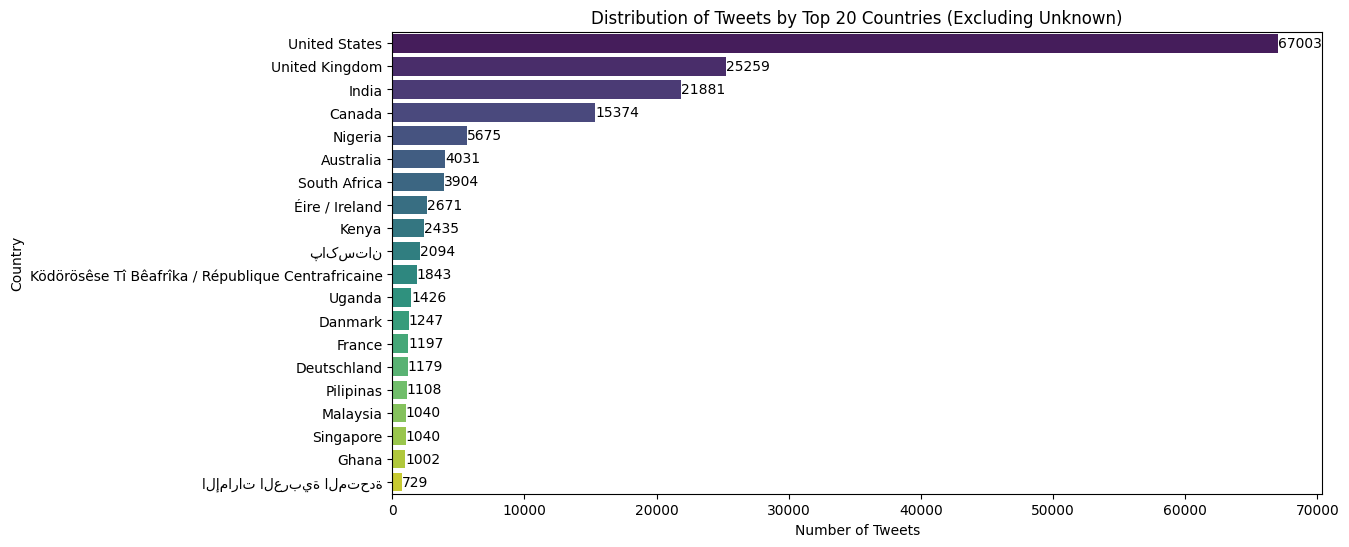

In [249]:
# 1. Country EDA: Remove 'Unknown' countries and plot histogram for top 20 (ordered)
known_countries = tweets_df[tweets_df['country'] != 'Unknown']
top_20_countries = known_countries['country'].value_counts().nlargest(20)

plt.figure(figsize=(12, 6))
sns.barplot(
    y=top_20_countries.index,
    x=top_20_countries.values,
    hue=top_20_countries.index,  # Assign y to hue
    palette='viridis',
    dodge=False,  # Ensure no splitting
    legend=False  # Disable legend
)
plt.title('Distribution of Tweets by Top 20 Countries (Excluding Unknown)')
plt.xlabel('Number of Tweets')
plt.ylabel('Country')
for i, v in enumerate(top_20_countries.values):
    plt.text(v, i, f"{v}", va='center')
plt.show()

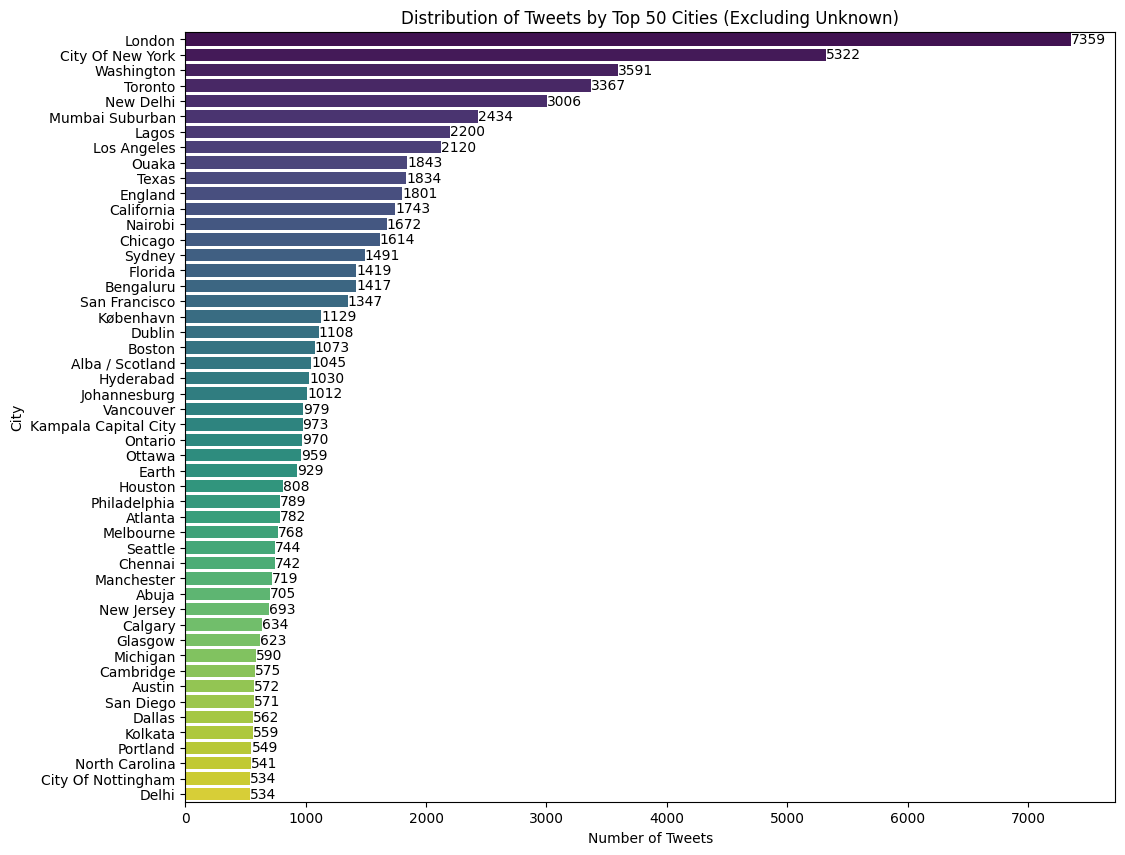

In [250]:
# 2. Remove 'Unknown' cities and plot histogram for top 50 (ordered)
known_cities = tweets_df[tweets_df['city'] != 'Unknown']
top_50_cities = known_cities['city'].value_counts().nlargest(50)

plt.figure(figsize=(12, 10))
sns.barplot(
    y=top_50_cities.index,
    x=top_50_cities.values,
    hue=top_50_cities.index,  # Assign y to hue
    palette='viridis',
    dodge=False,  # Ensure no splitting
    legend=False  # Disable legend
)
plt.title('Distribution of Tweets by Top 50 Cities (Excluding Unknown)')
plt.xlabel('Number of Tweets')
plt.ylabel('City')
for i, v in enumerate(top_50_cities.values):
    plt.text(v, i, f"{v}", va='center')
plt.show()

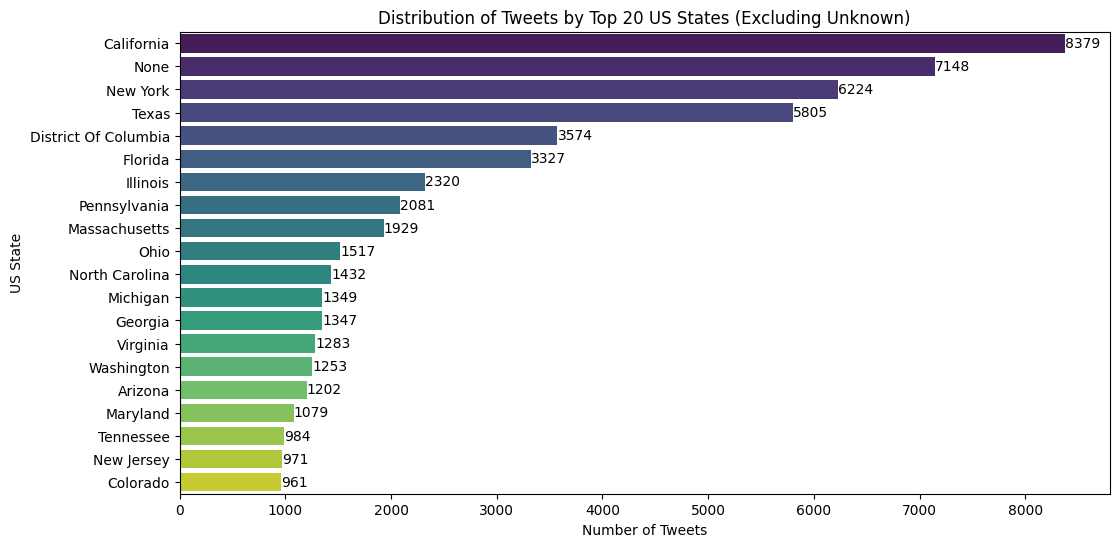

In [251]:
# Filter out 'Unknown' states and keep only US entries
us_states = tweets_df[(tweets_df['country'] == 'United States') & (tweets_df['state'] != 'Unknown')]

# Count occurrences of each state and get the top 20
state_counts = us_states['state'].value_counts().nlargest(20)

# Plot the distribution of tweets by the top 20 US states
plt.figure(figsize=(12, 6))
sns.barplot(
    y=state_counts.index,
    x=state_counts.values,
    hue=state_counts.index,  # Use state as hue
    palette='viridis',
    dodge=False,  # Prevent splitting bars
    legend=False  # Suppress the legend
)
plt.title('Distribution of Tweets by Top 20 US States (Excluding Unknown)')
plt.xlabel('Number of Tweets')
plt.ylabel('US State')

# Add labels to the bars
for i, v in enumerate(state_counts.values):
    plt.text(v, i, f"{v}", va='center')

plt.show()

In [252]:
# minor fixes: Move Florida, California, Texas, Michigan  from City to State and rename None in state to Unknown
states_as_cities = ['Florida', 'California', 'Texas', 'Michigan']
mask_states_as_cities = (tweets_df['city'].isin(states_as_cities)) & (tweets_df['country'] == 'United States')

# update State and City columns for these entries
tweets_df.loc[mask_states_as_cities, 'state'] = tweets_df.loc[mask_states_as_cities, 'city']
tweets_df.loc[mask_states_as_cities, 'city'] = 'Unknown'

# rename all 'None' in State to 'Unknown'
tweets_df['state'] = tweets_df['state'].replace('None', 'Unknown')

# fix "Alba/Scotland" entries
mask_alba_scotland = tweets_df['city'].str.contains('Alba/Scotland', case=False, na=False)

# update City and Country for Alba/Scotland
tweets_df.loc[mask_alba_scotland, 'city'] = 'Unknown'
tweets_df.loc[mask_alba_scotland, 'country'] = 'Scotland'

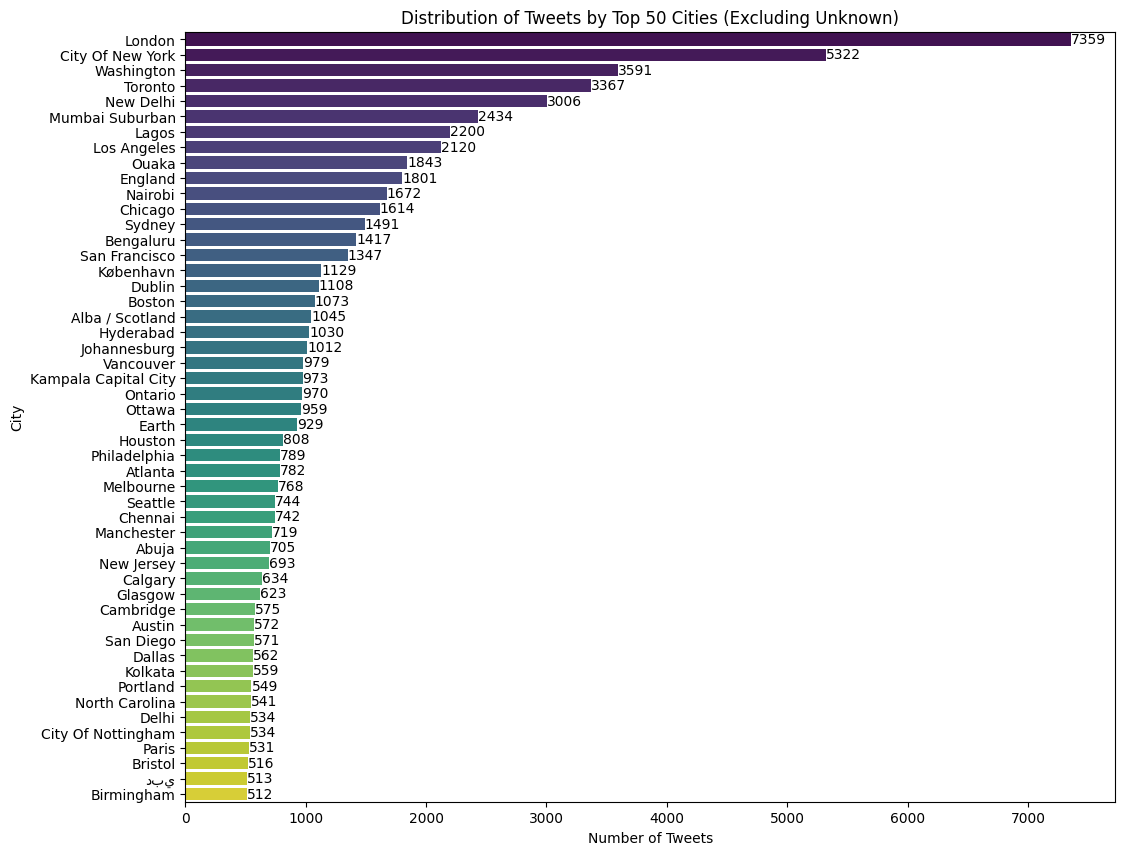

In [253]:
# redo the city plot:
# 2. Remove 'Unknown' cities and plot histogram for top 50 (ordered)
known_cities = tweets_df[tweets_df['city'] != 'Unknown']
top_50_cities = known_cities['city'].value_counts().nlargest(50)

plt.figure(figsize=(12, 10))
sns.barplot(
    y=top_50_cities.index,
    x=top_50_cities.values,
    hue=top_50_cities.index,  # Assign y to hue
    palette='viridis',
    dodge=False,  # Ensure no splitting
    legend=False  # Disable legend
)
plt.title('Distribution of Tweets by Top 50 Cities (Excluding Unknown)')
plt.xlabel('Number of Tweets')
plt.ylabel('City')
for i, v in enumerate(top_50_cities.values):
    plt.text(v, i, f"{v}", va='center')
plt.show()

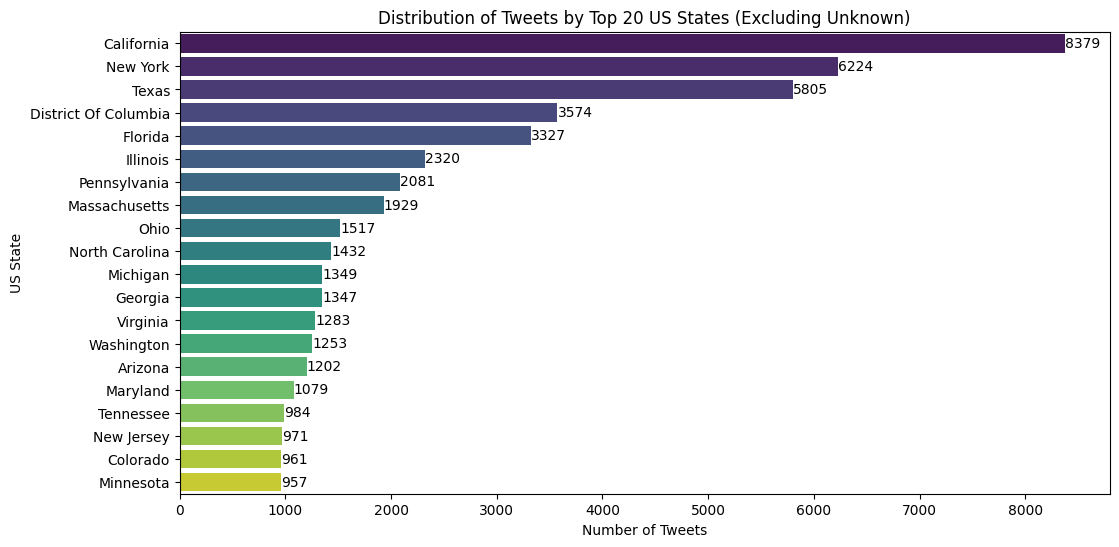

In [254]:
# redo the states plot:
# Filter out 'Unknown' states and keep only US entries
us_states = tweets_df[(tweets_df['country'] == 'United States') & (tweets_df['state'] != 'Unknown')]

# Count occurrences of each state and get the top 20
state_counts = us_states['state'].value_counts().nlargest(20)

# Plot the distribution of tweets by the top 20 US states
plt.figure(figsize=(12, 6))
sns.barplot(
    y=state_counts.index,
    x=state_counts.values,
    hue=state_counts.index,  # Use state as hue
    palette='viridis',
    dodge=False,  # Prevent splitting bars
    legend=False  # Suppress the legend
)
plt.title('Distribution of Tweets by Top 20 US States (Excluding Unknown)')
plt.xlabel('Number of Tweets')
plt.ylabel('US State')

# Add labels to the bars
for i, v in enumerate(state_counts.values):
    plt.text(v, i, f"{v}", va='center')

plt.show()

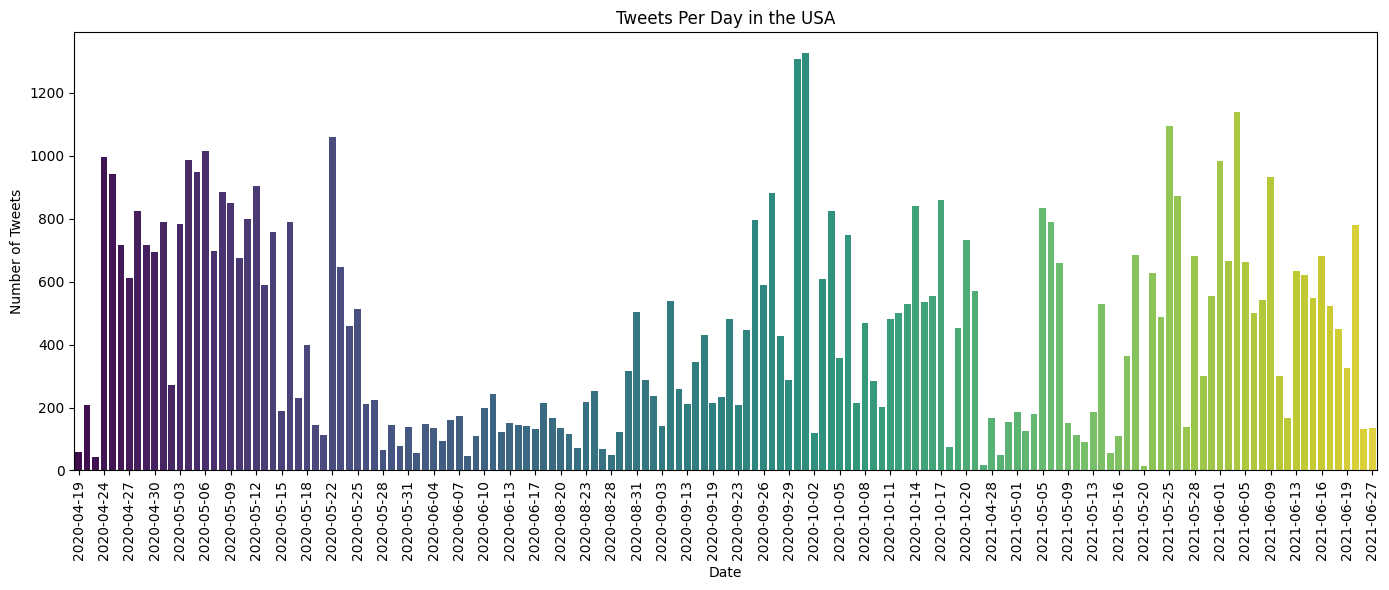

In [255]:
# USA tweets per day
usa_tweets = tweets_df[tweets_df['country'] == 'United States']

# group by date and count tweets per day
tweets_per_day = usa_tweets.groupby(usa_tweets['date'].dt.date).size().reset_index(name='Total Tweets')
tweets_per_day.columns = ['Date', 'Total Tweets']

# bar plot
plt.figure(figsize=(14, 6))
sns.barplot(
    data=tweets_per_day,
    x='Date',
    y='Total Tweets',
    hue='Date',  # Assign the x variable to hue
    palette='viridis',
    legend=False  # Disable the legend
)

# customize x-axis ticks to show every third date
xticks = plt.gca().get_xticks()
xtick_labels = tweets_per_day['Date'].astype(str).values
plt.xticks(
    ticks=xticks[::3],  # show every third tick
    labels=xtick_labels[::3],  # use corresponding labels
    rotation=90  # rotate 45 deg for better visibility
)

plt.xticks(rotation=90)  # rotate x-axis labels for better readability
plt.title('Tweets Per Day in the USA')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()

## [Optional] Adding lattitude, longitude.



In [256]:
tweets_df = add_coordinates_with_progress(tweets_df)

  5%|▍         | 57/1247 [02:47<58:23,  2.94s/it]


KeyboardInterrupt: 

In [ ]:
# Generate the map
heatmap = generateBaseMap(input_type="city", df=tweets_df)

# Save the map to an HTML file (optional)
heatmap.save("heatmap.html")

Next, we'll replace the ```source``` values with readable meaningful values using ```extract_html_source()``` function that will extract the value between the HTML tags.

In [257]:
# replace the source with the meaningful value
tweets_df.source.value_counts()

,count
source,
"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",122816
"<a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>",106325
"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",106135
"<a href=""http://twitter.com/#!/download/ipad"" rel=""nofollow"">Twitter for iPad</a>",14598
"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",6839
...,...
"<a href=""http://www.realway.com.br"" rel=""nofollow"">twitter.php</a>",1
"<a href=""http://www.indiapost.com"" rel=""nofollow"">IndiaPost</a>",1
"<a href=""https://help.twitter.com/en/using-twitter/how-to-tweet#source-labels"" rel=""nofollow"">loveisnottourismSP</a>",1


In [258]:
# apply the function to the 'source' column
tweets_df['source'] = tweets_df['source'].apply(extract_html_source)
# identify sources with counts less than 100
source_counts = tweets_df['source'].value_counts()
low_count_sources = source_counts[source_counts < 100].index

# replace low-count sources with 'Other'
tweets_df['source'] = tweets_df['source'].replace(low_count_sources, 'Other')
tweets_df['source'].value_counts()

,count
source,
Twitter for Android,122816
Twitter Web App,106325
Twitter for iPhone,106135
Other,15342
Twitter for iPad,14598
...,...
Sentir Radio Nowplaying,102
PulpNews,102
Fabrik.fm,101


<ipython-input-259-16eb44c21676>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


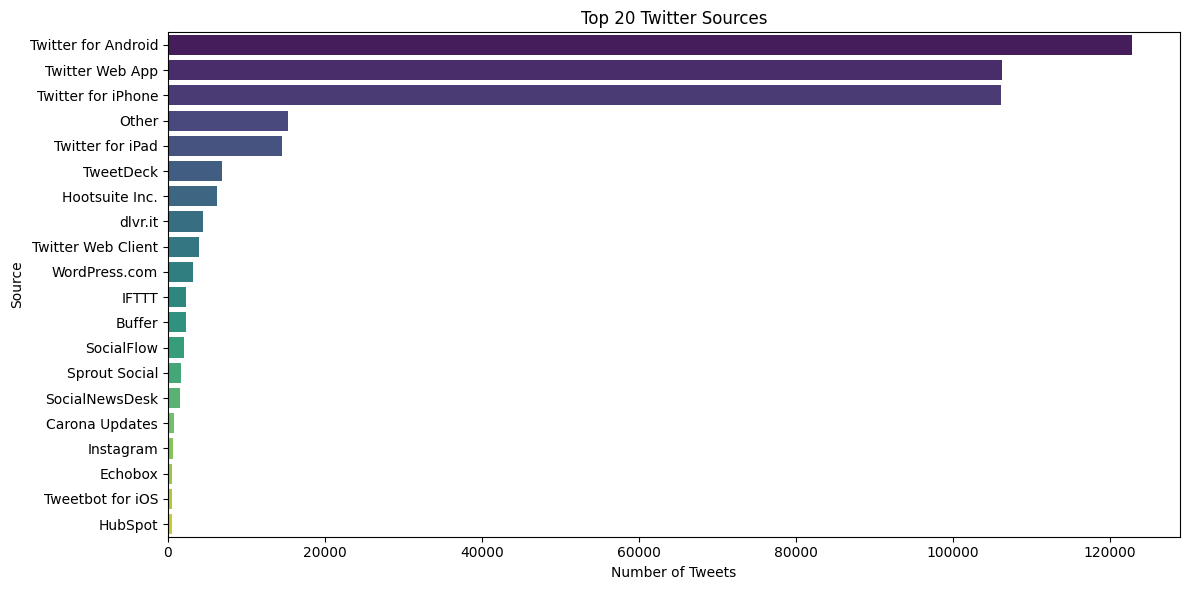

In [259]:
# plot the top 20 sources
top_20_sources = tweets_df['source'].value_counts().nlargest(20)

# Convert to a DataFrame for plotting
top_20_df = top_20_sources.reset_index()
top_20_df.columns = ['Source', 'Count']

# Plot the histogram
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_20_df,
    y='Source',
    x='Count',
    palette='viridis'
)
plt.title('Top 20 Twitter Sources')
plt.xlabel('Number of Tweets')
plt.ylabel('Source')
plt.tight_layout()
plt.show()

# Hashtags, mentions, likes, retweets.
Vanity fair, lookng at social engagement, connections, popularity.

* Hashtags word cloud.

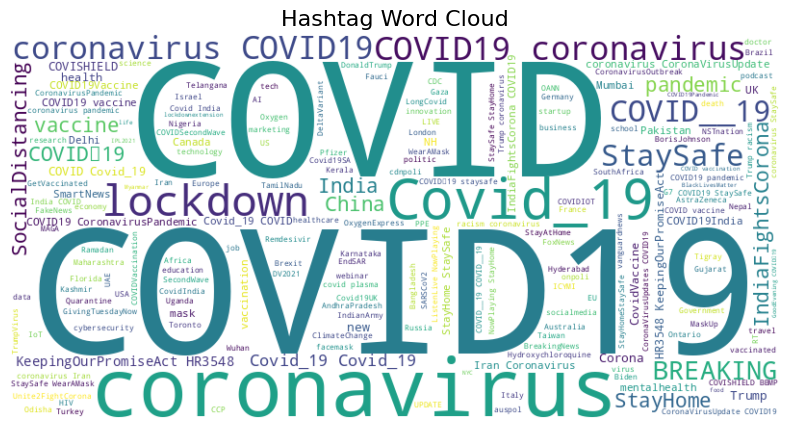

In [260]:
# Flatten the list of hashtags
all_hashtags = [
    ''.join(hashtags)  # Join characters into a string
    for hashtags in tweets_df['hashtags']
    if isinstance(hashtags, (list, tuple, str, np.ndarray))  # Check if iterable
]
# Convert the list of hashtags into a single string, separated by spaces
hashtag_text = ' '.join(all_hashtags)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, \
                      background_color='white', colormap='viridis').generate(hashtag_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Hashtag Word Cloud", fontsize=16)
plt.show()

* Histograms for favorite tweets, retweets.
Convert both to log scale because of the value range (wide range, outliers).


In [261]:
tweets_df.favorite_count.sort_values(ascending=False).head(50)

,favorite_count
247885,2923.0
29487,1166.0
185524,880.0
243406,676.0
177098,571.0
293194,554.0
156750,531.0
66990,438.0
84931,400.0
115775,393.0


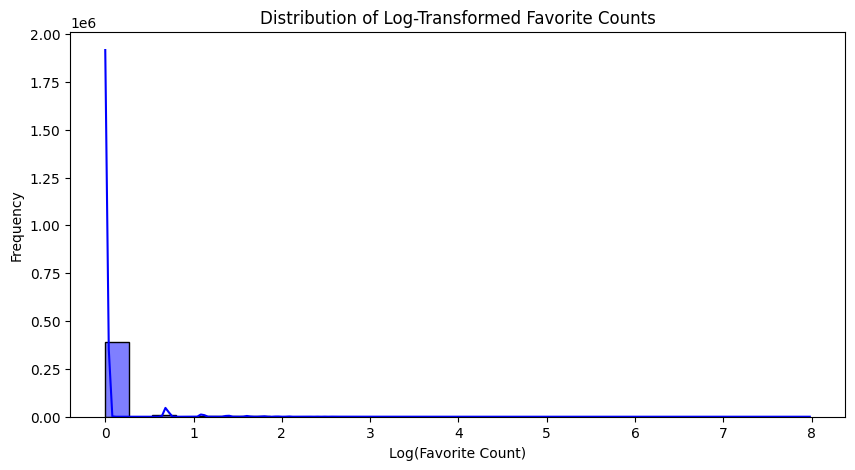

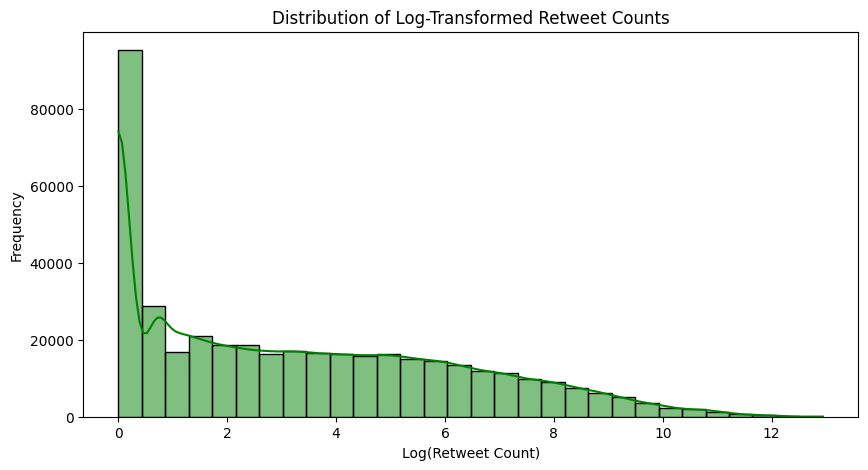

In [262]:
# Log-transform favorite_count (add 1 to avoid log(0))
tweets_df['log_favorite_count'] = np.log1p(tweets_df['favorite_count'])

# Histogram for log-transformed favorite_count
plt.figure(figsize=(10, 5))
sns.histplot(tweets_df['log_favorite_count'], bins=30, kde=True, color='blue')
plt.title('Distribution of Log-Transformed Favorite Counts')
plt.xlabel('Log(Favorite Count)')
plt.ylabel('Frequency')
plt.show()

# Log-transform retweet_count (add 1 to avoid log(0))
tweets_df['log_retweet_count'] = np.log1p(tweets_df['retweet_count'])

# Histogram for log-transformed retweet_count
plt.figure(figsize=(10, 5))
sns.histplot(tweets_df['log_retweet_count'], bins=30, kde=True, color='green')
plt.title('Distribution of Log-Transformed Retweet Counts')
plt.xlabel('Log(Retweet Count)')
plt.ylabel('Frequency')
plt.show()

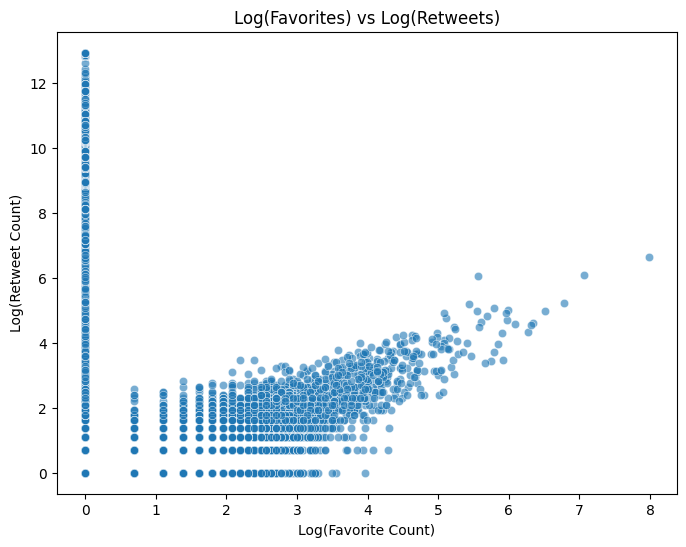

In [263]:
# Log-transform favorite_count and retweet_count (add 1 to avoid log(0))
tweets_df['log_favorite_count'] = np.log1p(tweets_df['favorite_count'])
tweets_df['log_retweet_count'] = np.log1p(tweets_df['retweet_count'])

# Scatter plot with log-transformed values
plt.figure(figsize=(8, 6))
sns.scatterplot(x='log_favorite_count', y='log_retweet_count', data=tweets_df, alpha=0.6)
plt.title('Log(Favorites) vs Log(Retweets)')
plt.xlabel('Log(Favorite Count)')
plt.ylabel('Log(Retweet Count)')
plt.show()

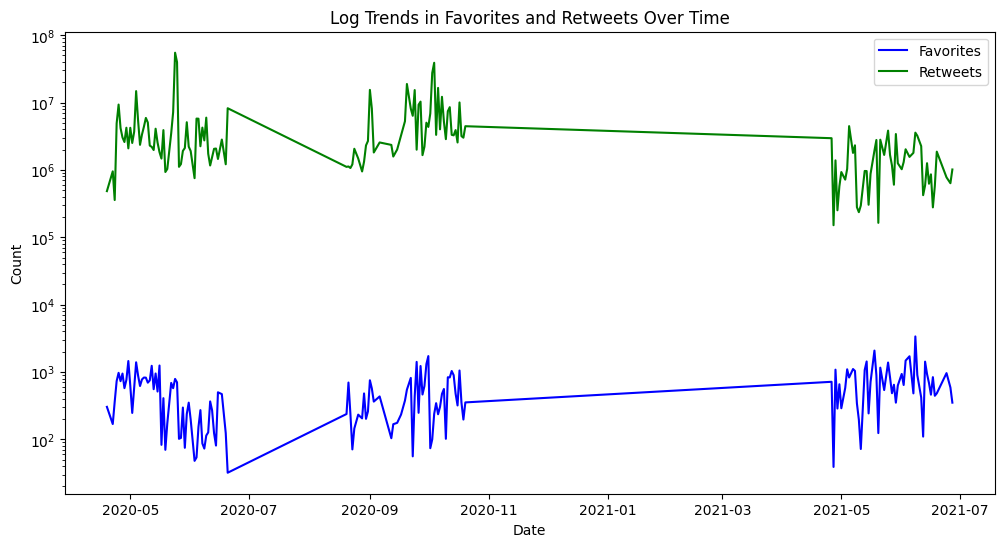

In [264]:
#  Show trends in favorites and retweets over time.
aggregated = tweets_df.groupby('date')[['favorite_count', 'retweet_count']].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='favorite_count', data=aggregated, label='Favorites', color='blue')
plt.yscale('log')
sns.lineplot(x='date', y='retweet_count', data=aggregated, label='Retweets', color='green')
plt.title('Log Trends in Favorites and Retweets Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

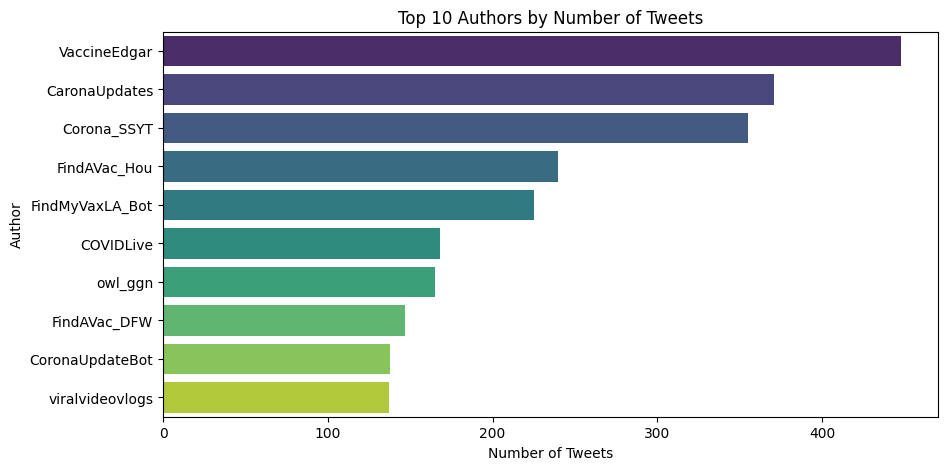

In [265]:
# top contributors by the number of tweets
top_authors = tweets_df['original_author'].value_counts().head(10)
# Bar Plot for Top Authors
plt.figure(figsize=(10, 5))
sns.barplot(
    x=top_authors.values,
    y=top_authors.index,
    hue=top_authors.index,  # Assign hue to the y variable
    palette='viridis',
    dodge=False,            # Ensure no splitting
    legend=False            # Disable the legend
)
plt.title('Top 10 Authors by Number of Tweets')
plt.xlabel('Number of Tweets')
plt.ylabel('Author')
plt.show()

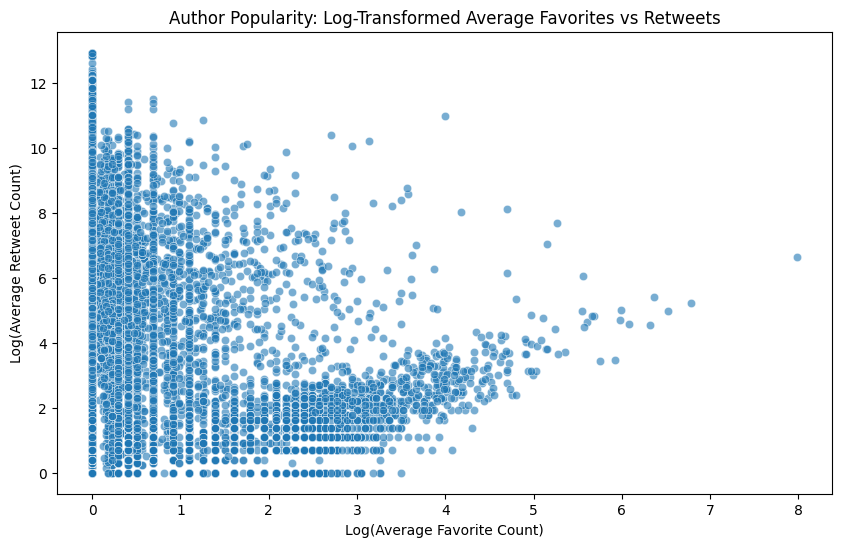

In [266]:
# Plot authors based on their average favorite_count and retweet_count
author_stats = tweets_df.groupby('original_author')[['favorite_count', \
                                                     'retweet_count']].mean().reset_index()

author_stats['log_favorite_count'] = np.log1p(author_stats['favorite_count'])
author_stats['log_retweet_count'] = np.log1p(author_stats['retweet_count'])

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='log_favorite_count', y='log_retweet_count', data=author_stats, alpha=0.6
)
plt.title('Author Popularity: Log-Transformed Average Favorites vs Retweets')
plt.xlabel('Log(Average Favorite Count)')
plt.ylabel('Log(Average Retweet Count)')
plt.show()

* Visualize the most mentioned users.

<ipython-input-267-a5a8f26f1726>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


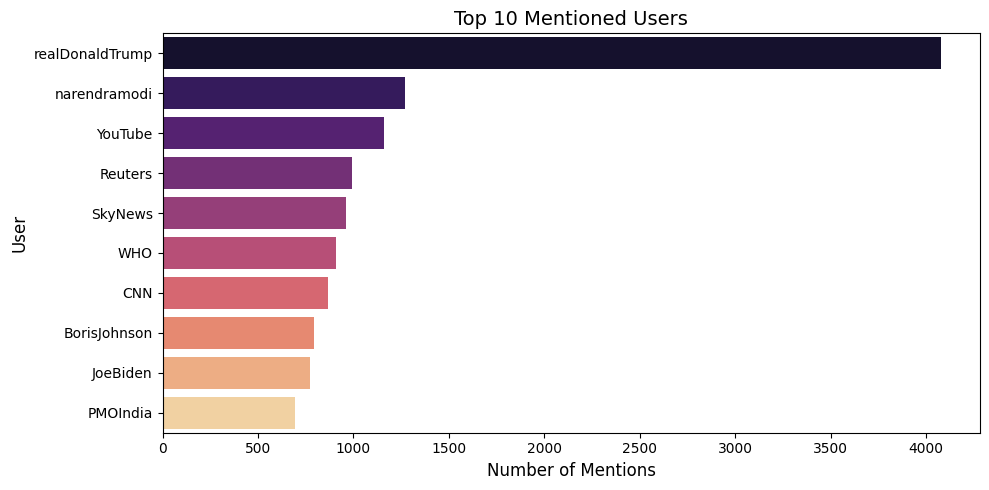

In [267]:
# Process user_mentions: split by comma and remove empty/malformed entries
tweets_df['user_mentions'] = tweets_df['user_mentions'].fillna('')  # Replace None with empty strings
tweets_df['user_mentions_clean'] = tweets_df['user_mentions'].apply(lambda x: [mention.strip() for mention in x.split(',') if mention.strip()])

# Flatten mentions and count frequencies
all_mentions = [mention for mentions in tweets_df['user_mentions_clean'] for mention in mentions]
mention_counts = Counter(all_mentions).most_common(10)

# Convert to DataFrame for visualization
mention_df = pd.DataFrame(mention_counts, columns=['user', 'count'])

# Plot the data
plt.figure(figsize=(10, 5))
sns.barplot(
    x='count',
    y='user',
    data=mention_df,
    hue='user',        # Assign hue to the y variable
    palette='magma',
    dodge=False,       # Prevent bar splitting
    legend=False       # Disable the legend
)
plt.title('Top 10 Mentioned Users', fontsize=14)
plt.xlabel('Number of Mentions', fontsize=12)
plt.ylabel('User', fontsize=12)
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

* Show the relationships between authors and mentioned users.

In [ ]:
# Create a directed graph
G = nx.DiGraph()

# Add edges (author -> mentioned user)
for _, row in tweets_df.iterrows():
    for mention in row['user_mentions_clean']:
        G.add_edge(row['original_author'], mention)

# Draw the graph
plt.figure(figsize=(12, 12))
nx.draw_networkx(
    G,
    node_size=50,
    alpha=0.7,
    font_size=8,
    edge_color='gray'
)
plt.title('User Mentions Network')
plt.show()

## Engagement Analysis.
* Display correlation between different metrics (e.g., favorites, retweets, mentions).

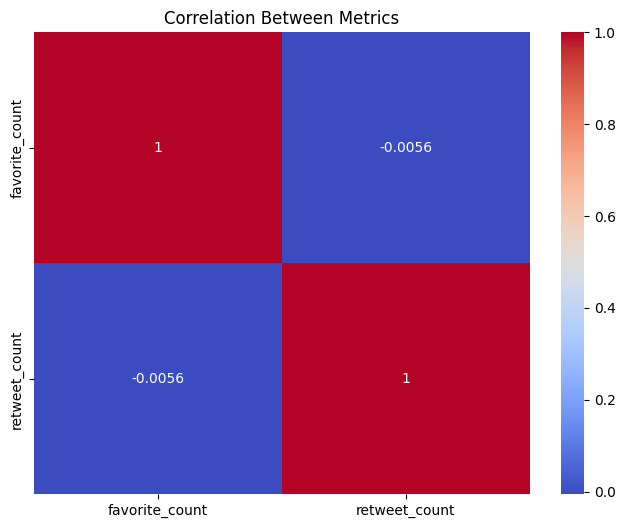

In [190]:
plt.figure(figsize=(8, 6))
sns.heatmap(tweets_df[['favorite_count', 'retweet_count']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Metrics')
plt.show()

* Visualize authors with bubbles representing their popularity.

In [ ]:
author_stats['tweet_count'] = tweets_df['original_author'].value_counts()

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='favorite_count',
    y='retweet_count',
    size='tweet_count',
    data=author_stats,
    sizes=(50, 500),
    alpha=0.7
)
plt.title('Author Popularity: Favorites vs Retweets with Tweet Count')
plt.xlabel('Average Favorite Count')
plt.ylabel('Average Retweet Count')
plt.legend(title='Tweet Count', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

### Cleaning the original twitter texts.
We wrote ```process_tweet_data()```to do the following:
* Remove and store emoji as a separate column(using default UNICODE_EMOJI).
* Remove and store mentions @ as a separate column.
* Remove and store retweets RT @ as a separate column.
* Remove and store hashtags # as a separate column.
* Remove and store URLs www. or t. or bit. as a separate column.
* Remove special characters, whitespaces, numbers.
* Lowercase and store text in ```cleaned_text``` column  

In [79]:
# example df
df_test = {
    'tweet_text': [
        "WOW!!! Check out this link: https://example.com :) @user123 #hashtag #fun",
        "RT @user456: Another day in paradise! 😃 #sunnyday",
        "Why so serious? :(( Visit www.example.org for details! #serious"
    ]
}
tweet_df = pd.DataFrame(df_test)

# Clean the text data
tweet_df = pd.concat([
    tweet_df,
    tweet_df['tweet_text'].apply(lambda x: pd.Series(process_tweet_data(x)))
], axis=1)
tweet_df

,tweet_text,mentions,hashtags,retweets,emojis,hyperlinks,cleaned_text
0,WOW!!! Check out this link: https://example.co...,[@user123],"[#hashtag, #fun]",[],😊,[https://example.com],wow check out this link smiling face with smil...
1,RT @user456: Another day in paradise! 😃 #sunnyday,[@user456],[#sunnyday],[user456],😃,[],another day in paradise grinning face with big...
2,Why so serious? :(( Visit www.example.org for ...,[],[#serious],[],☹,[www.example.org],why so serious frowning face visit for details


In [195]:
tweet_slice_df = tweets_df[['id', 'date', 'source', 'original_text', 'original_author', \
                            'favorite_count', 'retweet_count', \
                            'city', 'state', 'country']].copy()
# select a random sample of 20 entries
test_copy = tweet_slice_df.sample(n=20, random_state=42)  # Use random_state for reproducibility

# display the test_copy df
test_copy

,id,date,source,original_text,original_author,favorite_count,retweet_count,city,state,country
214198,1.398370e+18,2021-05-28,Twitter for iPhone,“The staff is proud of their work to provide n...,TheShakerite,1.0,1.0,Unknown,Unknown,Unknown
301931,1.300000e+18,2020-08-30,Twitter Web App,RT @Open_Referral: This week on our blog: a ro...,ArthurSmid,0.0,150.0,Portland,Oregon,United States
185212,1.394591e+18,2021-05-18,Twitter for Android,@ObaidaIdris @UniverCurious No gift “because y...,Alexand021l,0.0,54.0,Unknown,Unknown,Unknown
26611,1.260000e+18,2020-04-29,Twitter for iPhone,@piersmorgan Government are just manipulating ...,SteveVarley3,0.0,55.0,Unknown,Unknown,Unknown
129285,1.270000e+18,2020-06-03,Twitter for iPhone,RT @EducEndowFoundn: NEW: School closures as a...,RichardMEllam,0.0,164.0,Unknown,Unknown,Unknown
399299,1.320000e+18,2020-10-16,Twitter for iPad,RT @VisitScotland: Is this YOUR idea of paradi...,colinkbell63,0.0,1.0,Alba / Scotland,Alba / Scotland,United Kingdom
33962,1.260000e+18,2020-05-01,Twitter for Android,"RT @educommission: Learning from past crises, ...",tzDiscovery,0.0,0.0,Unknown,Unknown,Tanzania
153314,1.388499e+18,2021-05-01,Twitter Web App,RT @txsalth2o: Toddlers are 3 times more likel...,jacquesbs,0.0,0.0,Unknown,Unknown,Unknown
397308,1.320000e+18,2020-10-15,Twitter Web App,RT @Independent: Trump admits exposing chief o...,HumbertoZamoraR,1.0,0.0,Unknown,Unknown,Unknown
129826,1.270000e+18,2020-06-03,Twitter for iPhone,@babyy_phoenix You didn’t offend me but also b...,Lucifersumbreon,0.0,323.0,Washington,District Of Columbia,United States


In [197]:
# apply the function to test dataframeeach tweet and expand the results into separate columns
test_copy = pd.concat([
    test_copy,
    test_copy['original_text'].apply(lambda x: pd.Series(process_tweet_data(x)))
], axis=1)

test_copy.head()

,id,date,source,original_text,original_author,favorite_count,retweet_count,city,state,country,...,retweets,emojis,hyperlinks,cleaned_text,mentions,hashtags,retweets,emojis,hyperlinks,cleaned_text
214198,1.398370e+18,2021-05-28,Twitter for iPhone,“The staff is proud of their work to provide n...,TheShakerite,1.0,1.0,Unknown,Unknown,Unknown,...,[],,[https://t.co/CvxYarKQqr],“the staff is proud of their work to provide n...,[],[],[],,[https://t.co/CvxYarKQqr],“the staff is proud of their work to provide n...
301931,1.300000e+18,2020-08-30,Twitter Web App,RT @Open_Referral: This week on our blog: a ro...,ArthurSmid,0.0,150.0,Portland,Oregon,United States,...,[Open_Referral],,[https://t.co/fqi4OsPoQf],referral this week on our blog a roundup of re...,[@Open_Referral],[],[Open_Referral],,[https://t.co/fqi4OsPoQf],referral this week on our blog a roundup of re...
185212,1.394591e+18,2021-05-18,Twitter for Android,@ObaidaIdris @UniverCurious No gift “because y...,Alexand021l,0.0,54.0,Unknown,Unknown,Unknown,...,[],🤣,[],no gift “because you are too far” and covid ro...,"[@ObaidaIdris, @UniverCurious]",[],[],🤣,[],no gift “because you are too far” and covid ro...
26611,1.260000e+18,2020-04-29,Twitter for iPhone,@piersmorgan Government are just manipulating ...,SteveVarley3,0.0,55.0,Unknown,Unknown,Unknown,...,[],,[https://t.co/dYo7fBelWB],government are just manipulating the figures t...,[@piersmorgan],[],[],,[https://t.co/dYo7fBelWB],government are just manipulating the figures t...
129285,1.270000e+18,2020-06-03,Twitter for iPhone,RT @EducEndowFoundn: NEW: School closures as a...,RichardMEllam,0.0,164.0,Unknown,Unknown,Unknown,...,[EducEndowFoundn],,[],new school closures as a result of covid will ...,[@EducEndowFoundn],[],[EducEndowFoundn],,[],new school closures as a result of covid will ...


We'll apply text cleaning with progress to the entire function (takes about 80 minutes)

In [199]:
# apply the function to each tweet and expand the results into separate columns
tweet_df = clean_tweets_with_progress(tweets_df, text_col='original_text')
tweet_slice_df.head()

  0%|          | 1569/411884 [00:24<1:48:27, 63.06it/s]


KeyboardInterrupt: 

# Data pre-processing.

* Elaborate on the purpose of the pre-processing,
steps: tokenization, stop words, Lemmatization, n-grams




In [88]:
#test pre-processing (lemmatization)

preprocessed_df, ngram_matrix, ngram_vectorizer = preprocess_text_with_ngrams(
    tweet_df, text_column='cleaned_text', ngram_range=(2, 3), max_features=5000
)
# Display the preprocessed DataFrame
preprocessed_df[['cleaned_text', 'lemmatized_text']]

100%|██████████| 3/3 [00:00<00:00, 5302.53it/s]


,cleaned_text,lemmatized_text
0,wow check out this link smiling face with smil...,wow check link smiling face smiling eye
1,another day in paradise grinning face with big...,another day paradise grinning face big eye
2,why so serious frowning face visit for details,serious frowning face visit detail


In [89]:
# View n-gram feature names
print(ngram_vectorizer.get_feature_names_out())

['another day' 'another day paradise' 'big eye' 'check link'
 'check link smiling' 'day paradise' 'day paradise grinning' 'face big'
 'face big eye' 'face smiling' 'face smiling eye' 'face visit'
 'face visit detail' 'frowning face' 'frowning face visit' 'grinning face'
 'grinning face big' 'link smiling' 'link smiling face'
 'paradise grinning' 'paradise grinning face' 'serious frowning'
 'serious frowning face' 'smiling eye' 'smiling face'
 'smiling face smiling' 'visit detail' 'wow check' 'wow check link']


In [ ]:
# apply to dataframe

# Data Split

In [ ]:
from sklearn.model_selection import train_test_split

# Features and labels
X = tweet_df['cleaned_text']  # Preprocessed text
y = tweet_df['sentiment']     # Sentiment labels

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
# Bag of Words
vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=5000)
X_train_bow = vectorizer.fit_transform(X_train)
X_val_bow = vectorizer.transform(X_val)
X_test_bow = vectorizer.transform(X_test)

## Explore feature extraction
Try Bag of Words, TF-IDF, Embeddings (Bag of Words preffered)

# Classification Models

* Simple
* Complex

* -> to pipeline

## Save Model.

# Feature Interpretation

# Conclusions.